# Kredi Kartı Müşteri Segmentasyonu | Deep Learning Clustering

Bir bankanın kredi kartı müşterilerine ait işlem verilerini kullanarak **Autoencoder + K-Means** ile müşteri segmentasyonu. Her segment için pazarlama stratejileri geliştirilmektedir.

| Özellik | Detay |
|---------|-------|
| **Veri Seti** | CCGENERAL.csv — 8.950 müşteri, 18 özellik |
| **Problem Türü** | Kümeleme (Gözetimsiz Derin Öğrenme) |
| **Yöntem** | Autoencoder (17→128→64→32→8) + K-Means (k=4) |
| **Performans** | Silhouette: 0.309 · Davies-Bouldin: 1.190 · Calinski-Harabasz: 4672.7 |
| **Ön İşleme** | Median Imputer → StandardScaler → PCA (görselleştirme için) |

| Segment | Profil | Strateji |
|---------|--------|----------|
| Cluster 0 | Dengeli ve Ortalama Kullanıcı | Standart kampanyalar, karma teklif |
| Cluster 1 | İhtiyatlı ve Pasif Kullanıcı | Aktivasyon kampanyaları |
| Cluster 2 | Nakit Avans Odaklı / Borçlu | Risk yönetimi, borç yapılandırma |
| Cluster 3 | Yüksek Harcamalı Elit Müşteri | Premium hizmetler, özel danışman |

**İş Akışı:** Veri Yükleme → EDA → İmputation → Scaling → Autoencoder Eğitimi → K-Means → PCA Görselleştirme → Profilleme → Kayıt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Veri Yükleme (Data Loading)

In [1]:
# Uyarıları bastırmak için
import warnings
warnings.filterwarnings('ignore')

# Veri setini yükleme
df = pd.read_csv('CCGENERAL.csv')

# İlk 5 satırı gösterme
print("Veri Setinin İlk 5 Satırı:")
display(df.head())

Veri Setinin İlk 5 Satırı:


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Veri Setinin Yapısal İncelemesi

Verinin genel yapısını anlamak, doğru ön işleme adımlarını belirlemek için kritiktir. Bu aşamada kolonların veri tiplerini, eksik değer olup olmadığını ve temel istatistiksel dağılımlarını kontrol edeceğiz.

In [2]:
df.info()
print(df.isnull().sum())
display(df.describe().T)

Veri Seti Bilgileri (info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 no

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


### İlk Bulgular:
- `CUST_ID` kolonu müşteri kimliği olduğu için analizde kullanılmayacak, daha sonra çıkarılabilir.
- `MINIMUM_PAYMENTS` ve `CREDIT_LIMIT` kolonlarında önemli sayıda eksik değer bulunmaktadır. Bu eksik değerlerin doldurulması (imputation) gerekecektir.
- Kolonların çoğu sayısal (`float64`), bu da modelleme için işimizi kolaylaştırır.

# EDA (Exploratory Data Analysis)

Keşifçi Veri Analizi (EDA), verinin içindeki desenleri, anormallikleri ve ilişkileri görselleştirerek anlamamıza yardımcı olur. Bu bölümde, değişkenlerin dağılımlarını ve aralarındaki korelasyonları inceleyeceğiz.

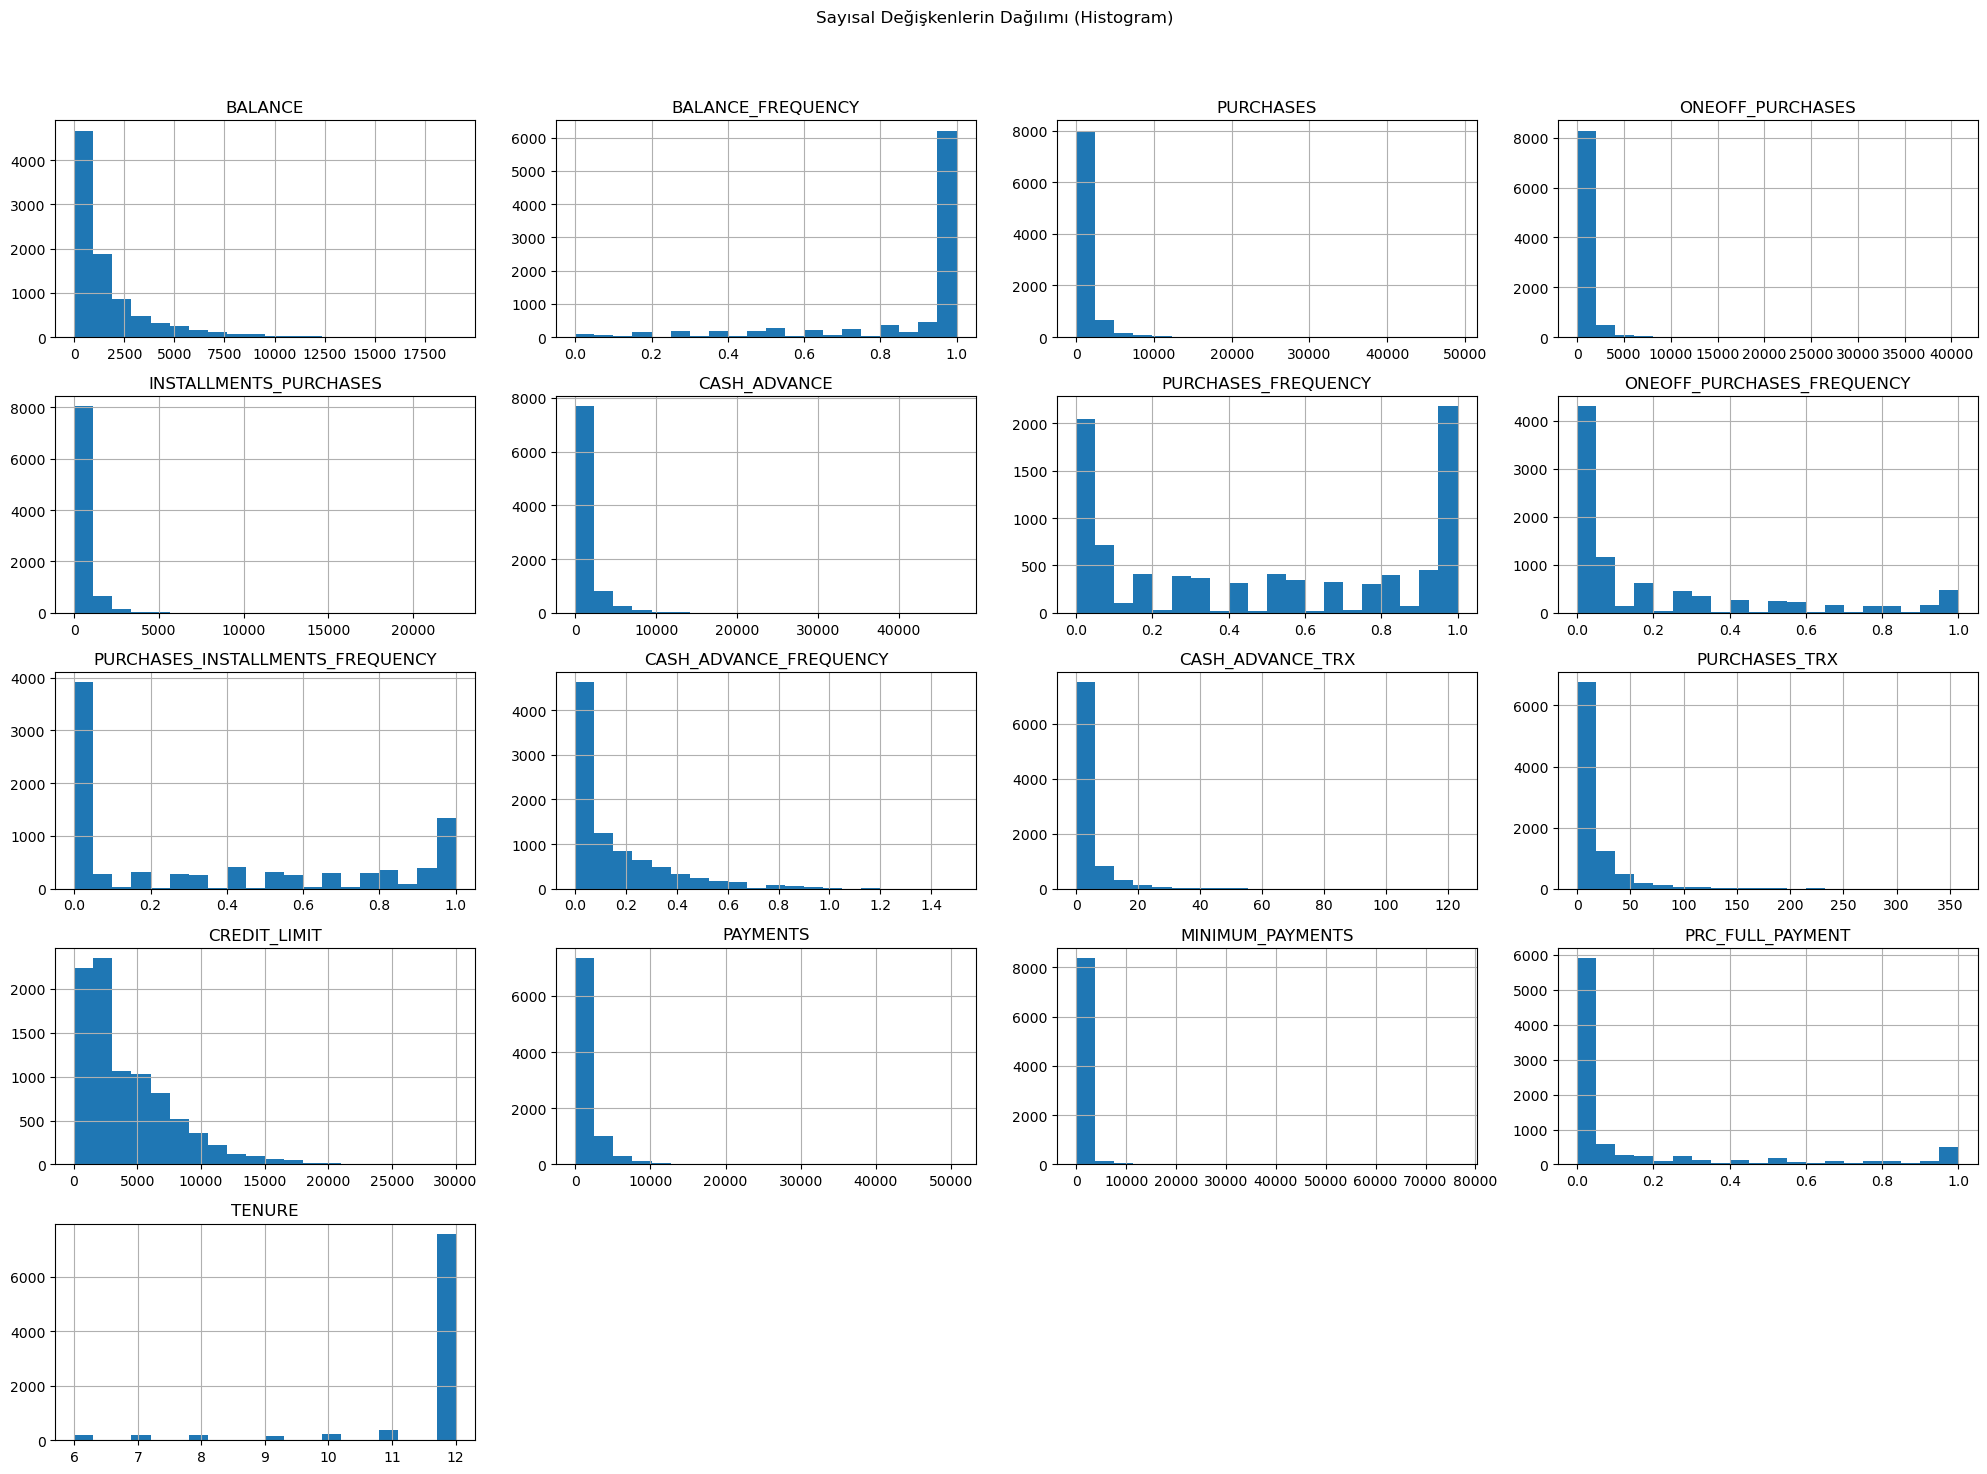

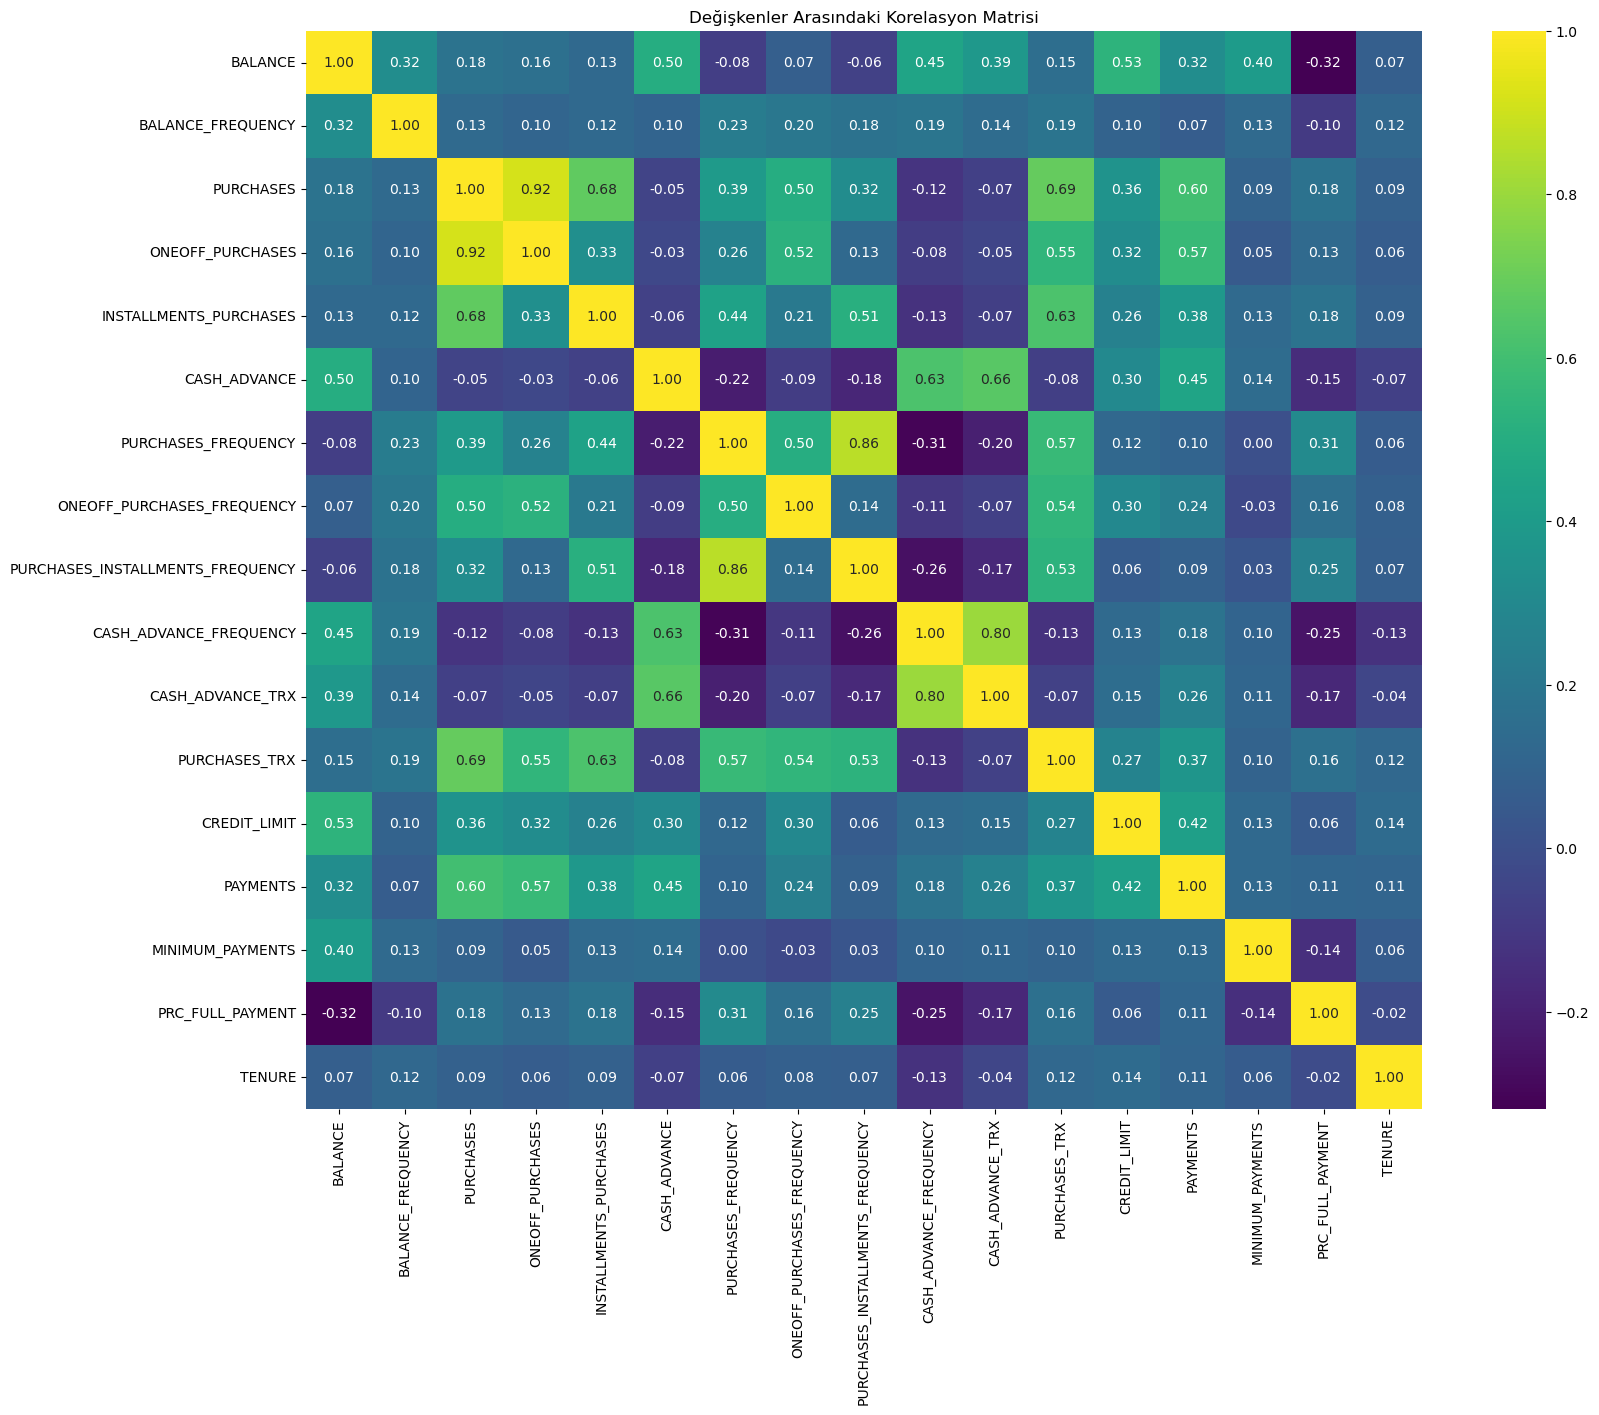

In [3]:
# CUST_ID kolonunu analizden çıkaralım
df_analysis = df.drop('CUST_ID', axis=1)

# Sayısal değişkenlerin dağılımını görmek için histogramlar
df_analysis.hist(bins=20, figsize=(20, 15), layout=(5, 4))
plt.suptitle('Sayısal Değişkenlerin Dağılımı (Histogram)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Korelasyon matrisi
plt.figure(figsize=(18, 14))
sns.heatmap(df_analysis.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Değişkenler Arasındaki Korelasyon Matrisi')
plt.show()

### EDA Yorumları:
- Histogramlar, birçok değişkenin (`BALANCE`, `PURCHASES`, `CASH_ADVANCE` vb.) sağa çarpık (right-skewed) bir dağılıma sahip olduğunu göstermektedir. Bu, müşterilerin çoğunun bu alanlarda düşük değerlere sahip olduğu, ancak az sayıda müşterinin çok yüksek değerlere sahip olduğu anlamına gelir.
- Korelasyon matrisi, bazı değişkenler arasında beklenen ilişkileri doğrulamaktadır:
  - `PURCHASES` ile `ONEOFF_PURCHASES` ve `INSTALLMENTS_PURCHASES` arasında güçlü pozitif korelasyon vardır. Bu mantıklıdır, çünkü toplam harcama, tek seferlik ve taksitli harcamaların birleşiminden etkilenir.
  - `PURCHASES_FREQUENCY` ile `PURCHASES_INSTALLMENTS_FREQUENCY` arasında da benzer bir ilişki görülmektedir.

# Veri Temizleme & Imputation

Modelimizin performansını olumsuz etkilememesi için veri setindeki eksik değerleri doldurmamız gerekiyor. Eksik değerler, genellikle çarpık dağılıma sahip oldukları için medyan (ortanca) değeri ile doldurulacaktır. Medyan, aykırı değerlerden daha az etkilendiği için bu tür dağılımlar için daha robust bir merkezi eğilim ölçüsüdür.

In [4]:
# Eksik değerleri medyan ile doldurma
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_analysis), columns=df_analysis.columns)

# Eksik değer kalıp kalmadığını kontrol edelim
print("Doldurma sonrası eksik değer sayısı:")
print(df_imputed.isnull().sum().sum())

Doldurma sonrası eksik değer sayısı:
0


# Feature Engineering

Bu aşamada, modelin daha iyi performans göstermesi için özellikleri dönüştüreceğiz.

### Ölçekleme (Scaling)
Farklı ölçeklerdeki (örneğin, `BALANCE` binlerce iken `PURCHASES_FREQUENCY` 0-1 arasında) değişkenler, uzaklık tabanlı algoritmalarda ve sinir ağlarında yanlılığa neden olabilir. `StandardScaler` kullanarak tüm değişkenleri ortalaması 0 ve standart sapması 1 olan bir dağılıma getirerek bu sorunu çözeceğiz. Bu, modelin tüm özellikleri eşit derecede önemli görmesini sağlar.

In [5]:
# Veriyi ölçeklendirme
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

print("Ölçeklenmiş verinin ilk 5 satırı:")
print(df_scaled[:5])

Ölçeklenmiş verinin ilk 5 satırı:
[[-0.73198937 -0.24943448 -0.42489974 -0.35693402 -0.34907882 -0.46678555
  -0.80649035 -0.67866081 -0.70731317 -0.67534886 -0.47606982 -0.51133325
  -0.9603784  -0.52897879 -0.3024     -0.52555097  0.36067954]
 [ 0.78696085  0.13432467 -0.46955188 -0.35693402 -0.45457623  2.60560451
  -1.22175806 -0.67866081 -0.91699519  0.57396272  0.11007385 -0.59179588
   0.68867844  0.81864213  0.09749953  0.2342269   0.36067954]
 [ 0.44713513  0.51808382 -0.10766823  0.10888851 -0.45457623 -0.46678555
   1.26984323  2.67345108 -0.91699519 -0.67534886 -0.47606982 -0.10902012
   0.82609984 -0.38380474 -0.0932934  -0.52555097  0.36067954]
 [ 0.04909914 -1.01695278  0.23205785  0.54618946 -0.45457623 -0.36865325
  -1.01412545 -0.39931927 -0.91699519 -0.25891333 -0.3295339  -0.55156456
   0.82609984 -0.59868826 -0.2283069  -0.52555097  0.36067954]
 [-0.3587753   0.51808382 -0.46206305 -0.34729428 -0.45457623 -0.46678555
  -1.01412545 -0.39931927 -0.91699519 -0.6753488

# Modelleme (Deep Learning)

Bu projede, etiketlenmemiş verilerde anlamlı temsiller (representations) öğrenme yeteneği nedeniyle bir Derin Öğrenme (Deep Learning) yaklaşımı kullanacağız. Geleneksel kümeleme algoritmaları (K-Means gibi) yüksek boyutlu verilerde zorlanabilirken, DL modelleri verinin daha düşük boyutlu ve yoğun bir temsilini öğrenerek bu sorunu aşabilir.

### Yaygın DL Tabanlı Kümeleme Algoritmaları
1. **Autoencoder:** Veriyi sıkıştırıp yeniden oluşturan bir sinir ağıdır. Sıkıştırılmış (encoded) katman, verinin anlamlı bir temsilini içerir.
2. **Deep Embedded Clustering (DEC):** Bir Autoencoder ile başlar ve ardından kümeleme odaklı bir loss fonksiyonu ile fine-tuning yapar.
3. **Variational Autoencoder (VAE):** Üretici bir modeldir ve verinin olasılıksal bir temsilini öğrenir.
4. **Self-Organizing Maps (SOM):** Veriyi düşük boyutlu bir grid üzerine haritalayan bir sinir ağı türüdür.
5. **Neural Gas:** SOM'a benzer şekilde çalışan ancak daha esnek bir topolojiye sahip bir algoritmadır.

### Proje için Seçilen Model: Autoencoder
Bu proje için **Autoencoder** kullanacağız. Seçimimizin nedenleri:
- **Anlaşılırlık:** Mimarisi (encoder-decoder) oldukça sezgisel  
- **Etkililik:** Yüksek boyutlu veriden düşük boyutlu, yoğun ve anlamlı özellikler çıkarmada çok başarılıdır.
- **Temel Oluşturma:** Autoencoder'dan elde edilen özellikler, K-Means gibi standart bir kümeleme algoritması için girdi olarak kullanılabilir. Bu, hibrit bir yaklaşım sunar ve DEC gibi daha karmaşık modellere geçmeden önce sağlam bir temel oluşturur.

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 17)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_1 (Dense)                    │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_2 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_3 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded_features (Dense)             │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Dense)                    │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_2 (Dense)                    │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_3 (Dense)                    │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 17)                  │           2,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,817 (100.85 KB)

 Trainable params: 25,817 (100.85 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder modeli eğitiliyor...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.8573 - val_loss: 0.6110
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4873 - val_loss: 0.3798
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3245 - val_loss: 0.2653
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2239 - val_loss: 0.1438
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1680 - val_loss: 0.1161
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1323 - val_loss: 0.0962
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1154 - val_loss: 0.0818
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1031 - val_loss: 0.0750
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0930 - val_loss: 0.0650
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0847 - val_loss: 0.0619
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0781 - val_loss: 0.0602
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 

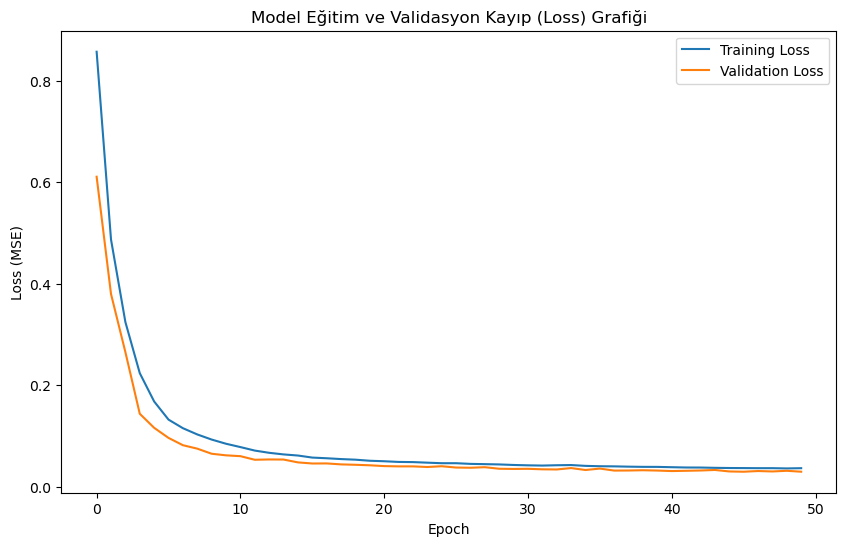

In [11]:
# Model Mimarisi
input_dim = df_scaled.shape[1] # 17 özellik
encoding_dim = 8 # Veriyi 8 boyuta sıkıştıracağız

# Encoder
input_layer = Input(shape=(input_dim,), name='input_layer')
encoder = Dense(128, activation='relu', name='encoder_1')(input_layer)
encoder = Dense(64, activation='relu', name='encoder_2')(encoder)
encoder = Dense(32, activation='relu', name='encoder_3')(encoder)
encoder = Dense(encoding_dim, activation='relu', name='encoded_features')(encoder)

# Decoder
decoder = Dense(32, activation='relu', name='decoder_1')(encoder)
decoder = Dense(64, activation='relu', name='decoder_2')(decoder)
decoder = Dense(128, activation='relu', name='decoder_3')(decoder)
decoder = Dense(input_dim, activation=None, name='output_layer')(decoder) # Çıkış katmanında lineer aktivasyon

# Autoencoder Modeli
autoencoder = Model(inputs=input_layer, outputs=decoder, name='Autoencoder')

# Modelin Derlenmesi
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Modelin Özetini Gösterme
autoencoder.summary()

# Modelin Eğitilmesi
history = autoencoder.fit(
    df_scaled,
    df_scaled, # Giriş ve çıkış aynı, çünkü amacı yeniden oluşturmak
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1, # Verinin %10'u validasyon için ayrılır
    verbose=1
)

# Eğitim Loss Grafiği
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Eğitim ve Validasyon Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Kümeleme Sonuçlarının Değerlendirilmesi

Autoencoder'ı eğittikten sonra, verinin sıkıştırılmış (encoded) temsilini elde etmek için sadece encoder kısmını kullanacağız. Bu düşük boyutlu temsiller, K-Means gibi geleneksel bir algoritma ile kümelemek için idealdir. Son olarak, kümeleme kalitesini metrikler ve görselleştirmeler ile değerlendireceğiz.

In [ ]:
# Sadece Encoder kısmını alarak yeni bir model oluşturma
encoder_model = Model(inputs=input_layer, outputs=encoder, name='Encoder')

# Ölçeklenmiş veriden sıkıştırılmış özellikleri elde etme
encoded_features = encoder_model.predict(df_scaled)

print(f"Orijinal veri boyutu: {df_scaled.shape}")
print(f"Sıkıştırılmış özellik boyutu: {encoded_features.shape}")

# K-Means ile kümeleme yapma
n_clusters = 4 # Örnek olarak 4 küme seçelim
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(encoded_features)

# Kümeleme metriklerini hesaplama
silhouette = silhouette_score(encoded_features, clusters)
davies_bouldin = davies_bouldin_score(encoded_features, clusters)
calinski_harabasz = calinski_harabasz_score(encoded_features, clusters)

print(f"\nSilhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

# Küme etiketlerini orijinal DataFrame'e ekleme
df_imputed['CLUSTER'] = clusters

### Kümeleme Metrikleri Yorumu:
- **Silhouette Score:** (-1 ile 1 arasında) 1'e ne kadar yakınsa, kümelerin o kadar yoğun ve iyi ayrılmış olduğu anlamına gelir.
- **Davies-Bouldin Index:** 0'a ne kadar yakınsa o kadar iyidir. Düşük bir değer, kümeler arası uzaklığın küme içi uzaklığa göre daha büyük olduğunu gösterir.
- **Calinski-Harabasz Index:** Ne kadar yüksekse o kadar iyidir. Kümeler arası varyansın küme içi varyansa oranını ölçer.

Bu metrikler, seçilen küme sayısının (`n_clusters`) ne kadar uygun olduğunu değerlendirmede bize yardımcı olur. Farklı küme sayıları deneyerek bu metrikleri optimize etmek mümkündür.

### Kümelerin Görselleştirilmesi

Kümeleri görselleştirmek için, yüksek boyutlu olan sıkıştırılmış özellikleri 2 boyuta indireceğiz. Bunun için PCA (Principal Component Analysis) kullanacağız.

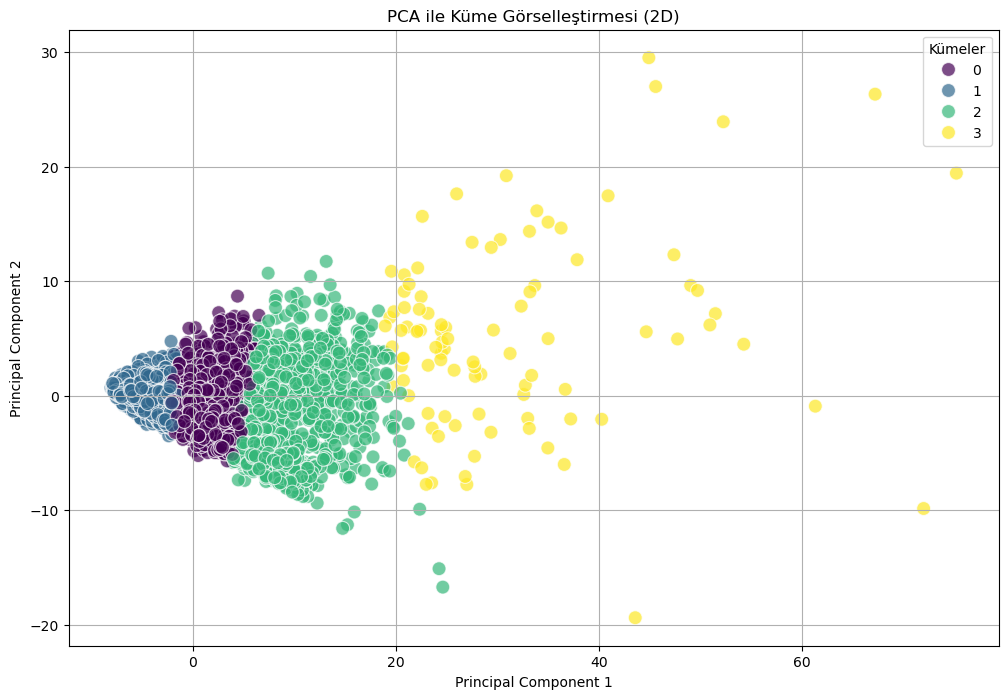

In [13]:
# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2)
principal_components = pca.fit_transform(encoded_features)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['CLUSTER'] = clusters

# 2D Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=df_pca, palette='viridis', s=100, alpha=0.7)
plt.title('PCA ile Küme Görselleştirmesi (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Kümeler')
plt.grid(True)
plt.show()

# Değerlendirme ve Sonuç

### Kümeleme Kalitesinin Yorumlanması
Elde edilen metrikler ve görselleştirme, modelimizin veriyi anlamlı gruplara ayırmada ne kadar başarılı olduğunu gösterir. Görselde, kümelerin ne kadar net ayrıştığı veya iç içe geçtiği görülebilir. Metrikler ise bu ayrımın sayısal bir ölçüsünü sunar.

### Küme Sayısının Yeterliliği
Bu projede başlangıç olarak 4 küme seçtik. Optimum küme sayısını bulmak için "Elbow Method" gibi teknikler veya farklı küme sayıları için metriklerin karşılaştırılması gerekebilir. Elde edilen küme profilleri (aşağıda incelenebilir) iş hedefleri açısından anlamlı değilse, küme sayısı yeniden değerlendirilmelidir.

### Küme Profillerinin Yorumlanması (Örnek)
Her bir kümenin ortalama değerlerine bakarak profiller oluşturabiliriz:

In [14]:
cluster_profile = df_imputed.groupby('CLUSTER').mean().T
display(cluster_profile)

CLUSTER,0,1,2,3
BALANCE,1337.063137,1154.276176,3069.365424,5315.376792
BALANCE_FREQUENCY,0.827795,0.914988,0.878178,0.968041
PURCHASES,1086.709677,392.241289,1823.770714,12346.835670
ONEOFF_PURCHASES,615.490870,256.707270,1032.479322,7768.639485
INSTALLMENTS_PURCHASES,471.471022,135.806773,791.809740,4578.196186
CASH_ADVANCE,808.412843,451.449147,2618.424547,5820.399132
PURCHASES_FREQUENCY,0.632506,0.338231,0.576603,0.817586
ONEOFF_PURCHASES_FREQUENCY,0.252006,0.120511,0.298552,0.601221
PURCHASES_INSTALLMENTS_FREQUENCY,0.484249,0.225517,0.463131,0.723560
CASH_ADVANCE_FREQUENCY,0.116794,0.096685,0.283649,0.278384


In [ ]:
 Küme 0: "Dengeli ve Ortalama Kullanıcı" ⚖️

   * Davranış Profili: Bu grup, kart özelliklerini dengeli bir şekilde kullanır. Ne aşırı harcama yaparlar ne de tamamen
     pasif kalırlar. Hem alışveriş hem de ihtiyaç anında nakit avans gibi özellikleri ılımlı bir şekilde kullanırlar.
     Banka için istikrarlı bir müşteri profilidir.
   * Veri ile Analiz:
       * Tüm metriklerde (Bakiye, Harcama, Nakit Avans) orta sıralarda yer alırlar.
       * PURCHASES (1086) ve CASH_ADVANCE (808) değerleri birbirine yakındır, bu da karma kullanımı gösterir.
   * Pazarlama Stratejisi: Mevsimsel kampanyalar, standart taksit seçenekleri ve kart kullanımını belirli alanlara (örn:
     e-ticaret, market) yönlendirecek bonus teklifleri ile etkileşimleri artırılabilir.

In [ ]:
 Küme 1: "İhtiyatlı ve Pasif Kullanıcı"  

   * Davranış Profili: Kredi kartını en az kullanan gruptur. Düşük limitleri vardır ve harcamaları, nakit avans
     kullanımları ve bakiyeleri tüm kümeler arasındaki en düşük seviyededir. Kartı büyük ihtimalle bir güvence olarak
     cüzdanlarında tutarlar.
   * Veri ile Analiz:
       * BALANCE (1154), PURCHASES (392), CASH_ADVANCE (451) ve CREDIT_LIMIT (2978) gibi neredeyse tüm temel
         göstergelerde en düşük değerlere sahiptirler.
   * Pazarlama Stratejisi: Kart kullanımını teşvik etmek için "hoş geldin" tarzı kampanyalar (ilk harcamaya
     indirim/puan) düzenlenebilir. Kartın sigorta, indirim gibi pasif faydaları hatırlatılarak kartla olan bağları
     güçlendirilebilir.

In [ ]:
  Küme 2: "Nakit Avans Odaklı ve Borçlu Müşteri" 💸

   * Davranış Profili: Bu müşteriler kredi kartını alışverişten çok bir finansman ve nakit ihtiyacı karşılama aracı
     olarak görürler. Grubun en belirgin özelliği, harcamalarından daha fazla nakit avans kullanmaları ve bunu sıkça
     yapmalarıdır. Yüksek bakiyeleri ve düşük tam ödeme oranları, borçlarını çevirmekte zorlandıklarını gösterir.
   * Veri ile Analiz:
       * CASH_ADVANCE (2618), PURCHASES (1823) değerinden belirgin şekilde yüksektir.
       * CASH_ADVANCE_FREQUENCY (0.28) tüm gruplar arasındaki en yüksek orandır.
       * PRC_FULL_PAYMENT (0.18) yani borcun tamamını ödeme oranı oldukça düşüktür.
   * Pazarlama Stratejisi: Risk yönetimi odaklı yaklaşılmalıdır. Borç yapılandırma, ödeme kolaylığı veya daha uygun
     faizli ihtiyaç kredisi gibi ürünler sunularak finansal sağlıkları iyileştirilebilir.

In [ ]:
Küme 3: "Yüksek Harcamalı Elit Müşteri" 💎

   * Davranış Profili: Bankanın en aktif ve en yüksek harcama yapan müşteri grubudur. Kredi limitleri ve harcama
     hacimleri diğer gruplardan katbekat fazladır. Yaptıkları yüksek ödemeler, harcama güçlerini ve sadakatlerini
     gösterir.
   * Veri ile Analiz:
       * PURCHASES (12346), CREDIT_LIMIT (12654) ve PAYMENTS (17050) gibi metriklerde diğer kümelerden ezici bir
         üstünlüğe sahiptirler.
       * PURCHASES_TRX (109), yani harcama işlem sayısı, ne kadar aktif olduklarının bir kanıtıdır.
   * Pazarlama Stratejisi: Bu gruba özel premium hizmetler sunulmalıdır. Kişiye özel kampanyalar, lüks marka iş
     birlikleri, seyahat ayrıcalıkları ve özel müşteri danışmanı gibi hizmetler bu grubu elde tutmak için kritiktir.


### Güçlü ve Zayıf Yönler
- **Güçlü Yön:** Derin öğrenme, doğrusal olmayan karmaşık ilişkileri yakalayarak daha anlamlı kümeler oluşturma potansiyeline sahiptir.
- **Zayıf Yön:** Autoencoder ve K-Means kombinasyonu, küme sayısının önceden belirlenmesini gerektirir ve sonuçlar başlangıç koşullarına duyarlı olabilir.

### İyileştirme Önerileri
- Farklı küme sayıları denenebilir.
- Daha karmaşık bir DL mimarisi (örn. DEC, VAE) kullanılabilir.
- Feature engineering adımları (örn. yeni özellikler türetme) zenginleştirilebilir.


# Modelin Kaydedilmesi

Streamlit uygulamasında kullanmak üzere eğitilmiş Autoencoder modelini ve `StandardScaler` nesnesini kaydediyoruz. Bu dosyalar, yeni verileri işlemek ve kümelemek için `streamlit_app.py` tarafından yüklenecektir.

In [15]:
import joblib

# Modelin kaydedileceği yollar
model_path = 'models/autoencoder_model.h5'
encoder_path = 'models/encoder_model.h5'
scaler_path = 'models/scaler.joblib'
imputer_path = 'models/imputer.joblib'
kmeans_path = 'models/kmeans.joblib'
pca_path = 'models/pca.joblib'

# Modelleri ve nesneleri kaydet
autoencoder.save(model_path)
encoder_model.save(encoder_path)
joblib.dump(scaler, scaler_path)
joblib.dump(imputer, imputer_path)
joblib.dump(kmeans, kmeans_path)
joblib.dump(pca, pca_path)


print(f"Autoencoder modeli kaydedildi: {model_path}")
print(f"Encoder modeli kaydedildi: {encoder_path}")
print(f"Scaler nesnesi kaydedildi: {scaler_path}")
print(f"Imputer nesnesi kaydedildi: {imputer_path}")
print(f"KMeans modeli kaydedildi: {kmeans_path}")
print(f"PCA modeli kaydedildi: {pca_path}")

Autoencoder modeli kaydedildi: models/autoencoder_model.h5
Encoder modeli kaydedildi: models/encoder_model.h5
Scaler nesnesi kaydedildi: models/scaler.joblib
Imputer nesnesi kaydedildi: models/imputer.joblib
KMeans modeli kaydedildi: models/kmeans.joblib
PCA modeli kaydedildi: models/pca.joblib


## Sonuç ve Değerlendirme

Bu proje, 8.950 kredi kartı müşterisini Autoencoder + K-Means hibrit yöntemiyle 4 anlamlı segmente ayırmıştır.

| Metrik | Değer | Yorum |
|--------|-------|-------|
| Silhouette Score | 0.309 | Makul küme ayrışımı |
| Davies-Bouldin Index | 1.190 | Düşük = iyi ayrışım |
| Calinski-Harabasz | 4672.7 | Yüksek = kompakt kümeler |

**Temel Bulgular:**
- Autoencoder, 17 boyutlu veriyi 8 boyutlu yoğun temsile sıkıştırarak anlamlı özellikler öğrenmiştir
- PCA görselleştirmesi, 4 kümenin uzayda net ayrışımını ortaya koymaktadır
- Cluster 3 (Elit Müşteriler) tüm harcama metriklerinde diğer segmentleri ezici biçimde geride bırakmaktadır
- Cluster 2 (Nakit Avans Odaklı) borçlanma riski açısından dikkat gerektiren bir segment oluşturmaktadır
- Bu segmentasyon, kişiselleştirilmiş pazarlama ve müşteri risk yönetimi için doğrudan kullanılabilir